In [225]:
# Get necessary imports
import os
import json
import pandas as pd
import numpy as np
import cv2
import boto3
import json
from datetime import datetime
from sklearn.metrics import pair_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
#necessary imports for Image
from PIL import Image


%matplotlib inline

#define constants
DATAPATH = '/Users/michaelscott/Documents/GitHub/datagen-repo/data'

# Create a dataframe to store the results
response_df = pd.DataFrame(columns=['id','angry_prob', 'calm_prob',
                           'surprised_prob','fear_prob','confused_prob','sad_prob',
                            'disgusted_prob', 'happy_prob'
                            ])

# Store response in a dictionary responses
# responses = {}

# Initialize an empty dictionary to hold the data
# data_dict = {}

# Initialize an emotion_dictionary
emotions = {
    'ANGRY': 'angry_prob',
    'CALM': 'calm_prob',
    'SURPRISED': 'surprised_prob',
    'FEAR': 'fear_prob',
    'CONFUSED': 'confused_prob',
    'SAD': 'sad_prob',
    'DISGUSTED': 'disgusted_prob',
    'HAPPY': 'happy_prob'
}

# Convert response_df['emotion_pred'] to the language of truth_df['expression'] using a emo_translate_dict 
# and then compare the two columns
emo_translate_dict = {
    'angry': 'anger',
    'calm': 'none',
    'surprised': 'surprise',
    'fear': 'fear',
    'confused': 'none',
    'sad': 'sadness',
    'disgusted': 'disgust',
    'happy': 'happiness'
}

# create a pd dataframe truth_df with the corresponding columns
# dataset_name	id	gender	age_range	ethnicity	expression	intensity
truth_df = pd.DataFrame(columns = ['id','gender','age_range','ethnicity','expression','intensity'])


In [222]:

# Rekognition Detect faces
def detect_faces(photo):
    
        client=boto3.client('rekognition')
    
        response = client.detect_faces(
            Image={
                'Bytes': photo
            }, 
            Attributes=[
                'ALL'
            ]
        )
        return response

# Get ground truth
def append_ground_truth(truth_df, dataset_name):
    data_dict = {}
    
    # Check if id has already been added to the dataframe
    if dataset_name in truth_df['id'].str.split('/').values:
        return truth_df
    
    # Loop over the datapoint directories
    datapoint_dir = f'/Users/michaelscott/Documents/GitHub/datagen-repo/data/{dataset_name}/'
    for datapoint_id in os.listdir(datapoint_dir):
        datapoint_path = os.path.join(datapoint_dir, datapoint_id)
        if not os.path.isdir(datapoint_path):
            continue

        # Extract the dataset name and ID from the datapoint path
        dataset_name = os.path.basename(os.path.dirname(datapoint_path))
        datapoint_id = os.path.basename(datapoint_path)

        # Load the JSON data from the datapoint request file
        datapoint_file = os.path.join(datapoint_path, 'datapoint_request.json')
        with open(datapoint_file, 'r') as f:
            data = json.load(f)

        # Load the actor metadata from the actor_metadata.json file
        metadata_file = os.path.join(datapoint_path, 'actor_metadata.json')
        with open(metadata_file, 'r') as f:
            metadata = json.load(f)

        # Extract the age range, ethnicity, and gender from the actor metadata
        age_range = metadata['identity_label']['age']
        ethnicity = metadata['identity_label']['ethnicity']
        gender = metadata['identity_label']['gender']
        demographics = {'gender': gender, 'age_range': age_range, 'ethnicity': ethnicity}

        # Extract the emotion data from the JSON data
        emotion = {}
        for datapoint in data['datapoints']:
            expression = datapoint['human']['head']['expression']['name']
            intensity = datapoint['human']['head']['expression']['intensity']
            emotion = {'expression': expression, 'intensity': intensity}

        # Concatenate the demographic and emotion information into a single dictionary
        data_dict[datapoint_id] = {'id': f'{dataset_name}/{datapoint_id}'}
        data_dict[datapoint_id].update(demographics)
        data_dict[datapoint_id].update(emotion)

    # Add data to the truth_df using pd concat
    # Do not concat the index of the data_dict
    truth_df = pd.concat([truth_df, pd.DataFrame.from_dict(data_dict, orient='index')], ignore_index=True)

    return truth_df

In [259]:
# Make prediction for one data point.
# Iterate through the images in the folder
from PIL import Image
def make_prediction(client, id, response_df, responses):
    # check if the datapoint has already been added to the dataframe
    # check if dataset_name is in dataset_name column
    # and also check if datapoint_id in id column
    # id = f'{dataset_name}/datapoint_{str(id).zfill(5)}'

    if id in response_df['id'].values:
        return response_df, responses
    
    # Check if already in responses
    if id not in responses.keys():
        print(f"Making prediction for {id}")
        with open(F"{DATAPATH}/{id}/camera_1/visible_spectrum_01.png", 'rb') as image:
            response = client.detect_faces(Image={
                'Bytes': image.read()
            },
            Attributes=['ALL'])

            # Store response in responses (dictionary) with the key as the name of the dataset + datapoint
            responses[id] = response
        
    else:
        print(f"Already made prediction for {id}")
        response = responses[id]

    # Iterate through the faces in the image
    for faceDetail in response['FaceDetails']:
        emotion_probs = {'id':id}
        for emotion in faceDetail['Emotions']:
            emotion_type = emotion['Type']
            emotion_prob = emotion['Confidence'] / 100
            column_name = emotions[emotion_type]
            emotion_probs[column_name] = emotion_prob

        # Create a new row in the dataframe with the emotion and confidence using pandas concat
        response_df = pd.concat([response_df, pd.DataFrame(emotion_probs, index=[len(response_df)])], ignore_index=True)
                
    # Create the column 'emotion_pred' that contains the emotion with the highest confidence
    response_df['emotion_pred'] = response_df[['angry_prob', 'calm_prob', 'surprised_prob', 'fear_prob', 'confused_prob', 'sad_prob', 'disgusted_prob', 'happy_prob']].idxmax(axis=1)

    # Replace '_prob' in the column 'emotion_prod' with empty
    response_df['emotion_pred'] = response_df['emotion_pred'].str.replace('_prob', '')

    return response_df, responses

In [443]:
# Visualize some of the images in a grid, 
# together with their predictions stored in pred_df
# do not show gridlines

# Sample images from one of each unique value of pred_df['emotion']
def visualize_images(pred_df, dataset_name, n_images=14, showlabels = True):
    # Select a random subset of n_images from the dataset
    dataset = pred_df[pred_df['id'].str.contains(dataset_name)]

    # Equally distribute n_images across each emotion
    sample = pd.DataFrame()
    for emotion in pred_df['expression'].unique().tolist():
        emotion_df = dataset[dataset['expression'] == emotion]
        emotion_sample = emotion_df.sample(int(n_images/len(pred_df['expression'].unique().tolist())))
        sample = pd.concat([sample, emotion_sample], ignore_index=True)
        
    # Create a figure with a grid of subplots
    fig, axes = plt.subplots(int(n_images/7), 7, figsize=(16, 6))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    
    # Loop over the images and display them
    for i, (index, row) in enumerate(sample.iterrows()):
        # Load the image
        image_path = os.path.join(DATAPATH, row['id'], 'camera_1', 'visible_spectrum_01.png')
        image = Image.open(image_path)
        
        # Add the image to the subplot
        ax = axes[i // 7, i % 7]
        ax.imshow(image)
        
        if showlabels:
            # Add the ground truth and prediction as the title
            title = f"Truth: {row['expression']}\nPrediction: {row['emotion_pred']}"
            ax.set_title(title)

        # Remove the gridlines from the subplot
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

# Start prediction

In [358]:
# Create a session object with the specified profile
session = boto3.Session(profile_name='default')

# Create an S3 client object using the session
client = session.client('rekognition',
                        region_name='ap-southeast-2')

In [410]:
for dataset in ['Sample_Humans_FB',
                'Faces_2023_04_03_02_11_04',
                'Faces_2023_04_03_04_25_04',
                'Faces_2023_04_03_05_16_04',
                'Faces_2023_04_03_07_11_04',
                'Faces_2023_04_03_23_11_04']:
    truth_df = append_ground_truth(truth_df, dataset).drop_duplicates()
truth_df

,id,gender,age_range,ethnicity,expression,intensity
0,Sample_Humans_FB/datapoint_00002,male,young,south_asian,fear,0.50
1,Sample_Humans_FB/datapoint_00005,female,young,hispanic,fear,0.75
2,Sample_Humans_FB/datapoint_00004,female,adult,southeast_asian,contempt,0.25
3,Sample_Humans_FB/datapoint_00003,male,adult,mediterranean,mouth_open,0.75
4,Sample_Humans_FB/datapoint_00010,female,young,mediterranean,fear,0.00
...,...,...,...,...,...,...
239,Faces_2023_04_03_23_11_04/datapoint_00009,male,adult,mediterranean,fear,1.00
240,Faces_2023_04_03_23_11_04/datapoint_00014,male,adult,mediterranean,sadness,1.00
241,Faces_2023_04_03_23_11_04/datapoint_00013,male,adult,hispanic,none,0.00
242,Faces_2023_04_03_23_11_04/datapoint_00012,male,adult,mediterranean,surprise,1.00


<Axes: xlabel='ethnicity', ylabel='gender'>

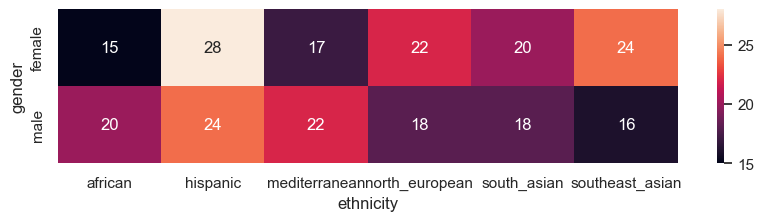

In [420]:
summary_df = truth_df.groupby(['gender','ethnicity']).count()['id']
# Convert summary_df from wide to long
summary_df.unstack(level=0)

# Plot summary_df using seaborn heatmap
fig, ax = plt.subplots(figsize=(10, 2))
sns.heatmap(summary_df.unstack(level=0).T, annot=True, fmt='d', ax=ax)

In [412]:
# use the make_prediction function using the existing response_df
# and responses dictionary
for i in range(1,8):
    response_df, responses = make_prediction(client, f'Faces_2023_04_03_02_11_04/datapoint_{str(i).zfill(5)}', response_df, responses)
# for i in range(1,11):
#     response_df, responses = make_prediction(client, f'Sample_Humans_FB/datapoint_{str(i).zfill(5)}', response_df, responses)
for i in range(1,8):
    response_df, responses = make_prediction(client, f'Faces_2023_04_03_04_25_04/datapoint_{str(i).zfill(5)}', response_df, responses)
for i in range(1,101):
    response_df, responses = make_prediction(client, f'Faces_2023_04_03_05_16_04/datapoint_{str(i).zfill(5)}', response_df, responses)

for i in range(1,101):
    response_df, responses = make_prediction(client, f'Faces_2023_04_03_07_11_04/datapoint_{str(i).zfill(5)}', response_df, responses)
for i in range(1,21):
    response_df, responses = make_prediction(client, f'Faces_2023_04_03_23_11_04/datapoint_{str(i).zfill(5)}', response_df, responses)
    

# Back up the variable "responses" into './backup' with the format responses_YYYY_MM_DD_HH_MM_SS.json using pickle
# Create a backup directory if it does not exist
backup_dir = './backup'
if not os.path.exists(backup_dir):
    os.makedirs(backup_dir)

# Create a timestamp for the backup file
timestamp = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

# Create the backup file path
backup_file = os.path.join(backup_dir, f'responses_{timestamp}.json')

# Save the responses dictionary to the backup file
with open(backup_file, 'w') as f:
    json.dump(responses, f)


Making prediction for Faces_2023_04_03_23_11_04/datapoint_00001
Making prediction for Faces_2023_04_03_23_11_04/datapoint_00002
Making prediction for Faces_2023_04_03_23_11_04/datapoint_00003
Making prediction for Faces_2023_04_03_23_11_04/datapoint_00004
Making prediction for Faces_2023_04_03_23_11_04/datapoint_00005
Making prediction for Faces_2023_04_03_23_11_04/datapoint_00006
Making prediction for Faces_2023_04_03_23_11_04/datapoint_00007
Making prediction for Faces_2023_04_03_23_11_04/datapoint_00008
Making prediction for Faces_2023_04_03_23_11_04/datapoint_00009
Making prediction for Faces_2023_04_03_23_11_04/datapoint_00010
Making prediction for Faces_2023_04_03_23_11_04/datapoint_00011
Making prediction for Faces_2023_04_03_23_11_04/datapoint_00012
Making prediction for Faces_2023_04_03_23_11_04/datapoint_00013
Making prediction for Faces_2023_04_03_23_11_04/datapoint_00014
Making prediction for Faces_2023_04_03_23_11_04/datapoint_00015
Making prediction for Faces_2023_04_03_2

In [413]:
response_df

,id,angry_prob,calm_prob,surprised_prob,fear_prob,confused_prob,sad_prob,disgusted_prob,happy_prob,emotion_pred
0,Faces_2023_04_03_02_11_04/datapoint_00001,0.092539,0.106487,0.078170,0.518249,0.017928,0.302001,0.060426,0.061964,fear
1,Faces_2023_04_03_02_11_04/datapoint_00002,0.006876,0.012539,0.069311,0.082098,0.031794,0.999767,0.018120,0.011466,sad
2,Faces_2023_04_03_02_11_04/datapoint_00003,0.237452,0.092433,0.082709,0.076257,0.061132,0.057937,0.083419,0.376746,happy
3,Faces_2023_04_03_02_11_04/datapoint_00004,0.011559,0.128181,0.076260,0.110544,0.690826,0.031569,0.009843,0.004508,confused
4,Faces_2023_04_03_02_11_04/datapoint_00005,0.483930,0.426848,0.073402,0.060441,0.007442,0.030837,0.026000,0.005271,angry
...,...,...,...,...,...,...,...,...,...,...
229,Faces_2023_04_03_23_11_04/datapoint_00016,0.705683,0.089951,0.082048,0.065402,0.065361,0.030427,0.055015,0.007896,angry
230,Faces_2023_04_03_23_11_04/datapoint_00017,0.023837,0.611145,0.083721,0.091997,0.022499,0.288763,0.016605,0.012929,calm
231,Faces_2023_04_03_23_11_04/datapoint_00018,0.785729,0.018487,0.066736,0.068054,0.051205,0.029915,0.069453,0.019810,angry
232,Faces_2023_04_03_23_11_04/datapoint_00019,0.001385,0.001809,0.888373,0.531634,0.003613,0.022206,0.002046,0.001684,surprised


In [421]:
# Merge response_df and truth_df
pred_df = response_df.merge(truth_df, how = 'left', on = ['id']).drop_duplicates()

pred_df['emotion_pred'] = pred_df['emotion_pred'].map(emo_translate_dict)

pred_df

,id,angry_prob,calm_prob,surprised_prob,fear_prob,confused_prob,sad_prob,disgusted_prob,happy_prob,emotion_pred,gender,age_range,ethnicity,expression,intensity
0,Faces_2023_04_03_02_11_04/datapoint_00001,0.092539,0.106487,0.078170,0.518249,0.017928,0.302001,0.060426,0.061964,fear,female,adult,north_european,none,0.0
1,Faces_2023_04_03_02_11_04/datapoint_00002,0.006876,0.012539,0.069311,0.082098,0.031794,0.999767,0.018120,0.011466,sadness,male,adult,south_asian,happiness,1.0
2,Faces_2023_04_03_02_11_04/datapoint_00003,0.237452,0.092433,0.082709,0.076257,0.061132,0.057937,0.083419,0.376746,happiness,female,adult,south_asian,happiness,1.0
3,Faces_2023_04_03_02_11_04/datapoint_00004,0.011559,0.128181,0.076260,0.110544,0.690826,0.031569,0.009843,0.004508,none,male,adult,south_asian,none,0.0
4,Faces_2023_04_03_02_11_04/datapoint_00005,0.483930,0.426848,0.073402,0.060441,0.007442,0.030837,0.026000,0.005271,anger,female,adult,southeast_asian,anger,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,Faces_2023_04_03_23_11_04/datapoint_00016,0.705683,0.089951,0.082048,0.065402,0.065361,0.030427,0.055015,0.007896,anger,male,adult,hispanic,disgust,1.0
230,Faces_2023_04_03_23_11_04/datapoint_00017,0.023837,0.611145,0.083721,0.091997,0.022499,0.288763,0.016605,0.012929,none,male,adult,mediterranean,sadness,1.0
231,Faces_2023_04_03_23_11_04/datapoint_00018,0.785729,0.018487,0.066736,0.068054,0.051205,0.029915,0.069453,0.019810,anger,male,adult,mediterranean,disgust,1.0
232,Faces_2023_04_03_23_11_04/datapoint_00019,0.001385,0.001809,0.888373,0.531634,0.003613,0.022206,0.002046,0.001684,surprise,male,adult,hispanic,surprise,1.0


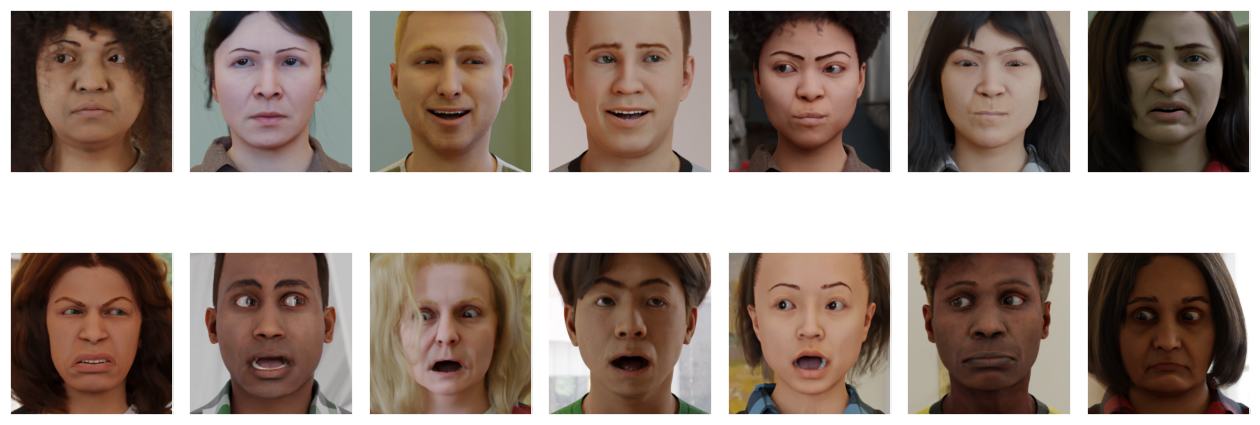

In [444]:
visualize_images(pred_df, 'Faces_2023_04_03_07_11_04', showlabels=False, n_images=14)

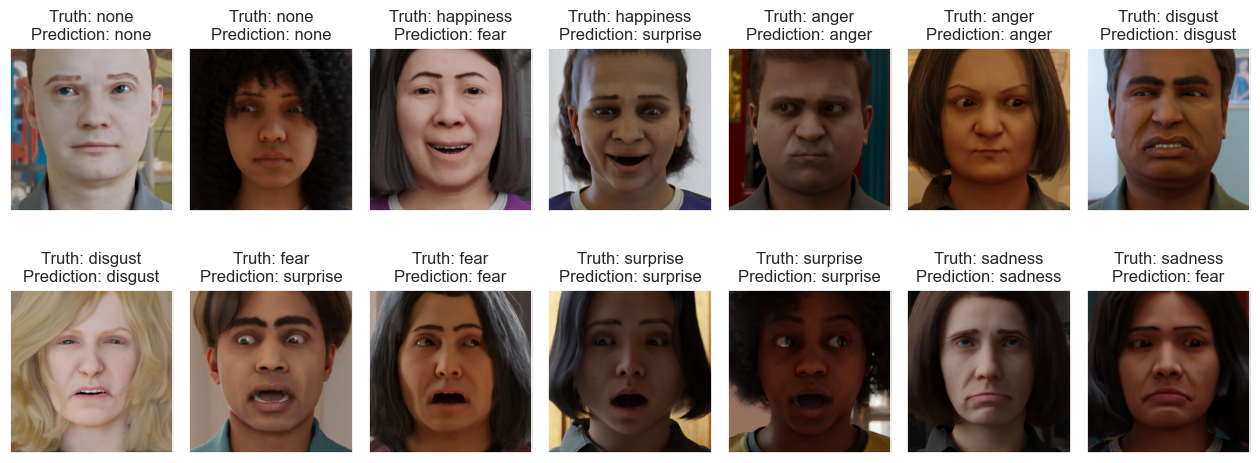

In [445]:
visualize_images(pred_df, 'Faces_2023_04_03_05_16_04')

<Axes: xlabel='Predicted', ylabel='True'>

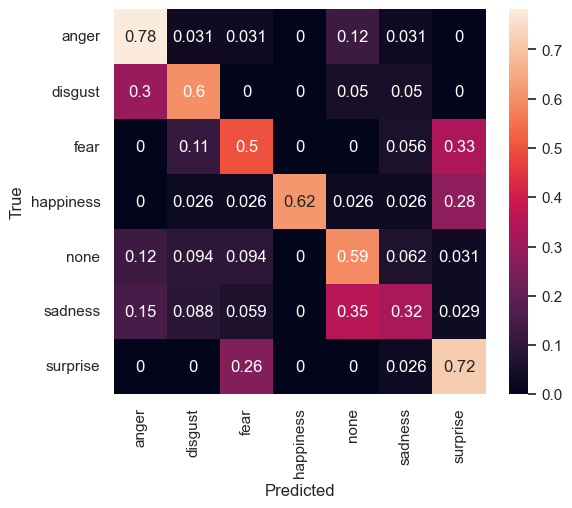

In [422]:
# Plot the confusion matrix with the corresponding labels
# Do not select the row and column with index 'all'
cm_df = pd.crosstab(pred_df['expression'], pred_df['emotion_pred'], rownames=['True'], colnames=['Predicted'], margins=True).iloc[:-1,:-1]
#normalize by row
cm_df = cm_df.div(cm_df.sum(axis=1), axis=0)

# Plot confusion matrix with the corresponding labels
plt.figure(figsize=(6,5))

# use seaborn to plot the confusion matrix
# normalize the dataset
sns.heatmap(cm_df, annot=True)

In [423]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.explainers import MetricTextExplainer
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd

# Assume that pred_df is the dataframe containing model predictions, including the columns "gender", "ethnicity",
# "expression", and "emotion_pred"
# Let's create a BinaryLabelDataset from the dataframe
sensitive_attrs = ["gender", "ethnicity"]
pred_df["emotion_correct"] = pred_df["expression"] == pred_df["emotion_pred"]
pred_df["emotion_correct"] = pred_df["emotion_correct"].astype(int)

# Convert all none numerical variables in ["gender", "ethnicity","emotion_pred","expression","emotion_correct"] to numerical using pd.get_dummies
# select the non-numerical columns
cat_cols = ["gender", "ethnicity", "emotion_pred", "expression", "emotion_correct"]

fairness_df = pred_df[cat_cols].copy()
# create the encoder and fit it to the categorical data
encoder = OrdinalEncoder()
encoder.fit(fairness_df[cat_cols])

# transform the categorical data into numerical values
fairness_df[cat_cols] = encoder.transform(fairness_df[cat_cols])

bld = BinaryLabelDataset(df=fairness_df[cat_cols].astype(int), 
                         label_names=["emotion_correct"], 
                          protected_attribute_names=sensitive_attrs, 
                          favorable_label=1, unfavorable_label=0)

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric

# assume that we have already created the BinaryLabelDataset bld from pred_df
# metric_pred = BinaryLabelDatasetMetric(bld, 
#                                        unprivileged_groups=[{"gender": 0, "ethnicity": 0}], 
#                                        privileged_groups=[{"gender": 1, "ethnicity": 1}])

# "Gender mapping"
gender_mapping = dict(zip(range(len(encoder.categories_[0])), encoder.categories_[0]))
print(f"Is {gender_mapping[1]} priviledged compared to {gender_mapping[0]}?")
metric_pred = BinaryLabelDatasetMetric(bld, 
                                       unprivileged_groups=[{"gender": 0}], 
                                       privileged_groups=[{"gender": 1}])

print("Disparate Impact: {:.2f}".format(metric_pred.disparate_impact()))
print("Statistical Parity: {:.2f}".format(metric_pred.statistical_parity_difference()))
print("Consistency: {:.2f}".format(metric_pred.consistency()[0]))
print("Smoothed EDF: {:.2f}".format(metric_pred.smoothed_empirical_differential_fairness()))


Is male priviledged compared to female?
Disparate Impact: 1.44
Statistical Parity: 0.22
Consistency: 0.90
Smoothed EDF: 1.02


In [424]:
ethnic_mapping = dict(zip(range(len(encoder.categories_[1])), encoder.categories_[1]))

for ethnic_encoded in range(6):
    print(f"Is {ethnic_mapping[ethnic_encoded]} priviledged compared to other ethnics?")
    metric_pred = BinaryLabelDatasetMetric(bld, 
                                        unprivileged_groups=[{"ethnicity": i} for i in range(6) if i != ethnic_encoded], 
                                        privileged_groups=[{"ethnicity": ethnic_encoded}])

    print("Disparate Impact: {:.2f}".format(metric_pred.disparate_impact()))
    print("Statistical Parity: {:.2f}".format(metric_pred.statistical_parity_difference()))
    print("Consistency: {:.2f}".format(metric_pred.consistency()[0]))
    print("Smoothed EDF: {:.2f}".format(metric_pred.smoothed_empirical_differential_fairness()))
    print("\n")

Is african priviledged compared to other ethnics?
Disparate Impact: 1.02
Statistical Parity: 0.01
Consistency: 0.90
Smoothed EDF: 1.02


Is hispanic priviledged compared to other ethnics?
Disparate Impact: 1.04
Statistical Parity: 0.02
Consistency: 0.90
Smoothed EDF: 1.02


Is mediterranean priviledged compared to other ethnics?
Disparate Impact: 1.01
Statistical Parity: 0.00
Consistency: 0.90
Smoothed EDF: 1.02


Is north_european priviledged compared to other ethnics?
Disparate Impact: 0.88
Statistical Parity: -0.08
Consistency: 0.90
Smoothed EDF: 1.02


Is south_asian priviledged compared to other ethnics?
Disparate Impact: 1.16
Statistical Parity: 0.08
Consistency: 0.90
Smoothed EDF: 1.02


Is southeast_asian priviledged compared to other ethnics?
Disparate Impact: 0.94
Statistical Parity: -0.04
Consistency: 0.90
Smoothed EDF: 1.02




In [425]:
for gender_encoded in range(2):
    for ethnic_encoded in range(6):
        print(f"Is {ethnic_mapping[ethnic_encoded]} {gender_mapping[gender_encoded]} priviledged compared to other groups?")
        metric_pred = BinaryLabelDatasetMetric(bld, 
                                            unprivileged_groups=[{"gender": 1-gender_encoded, "ethnicity": i} for i in range(6) if i != ethnic_encoded], 
                                            privileged_groups=[{"gender": gender_encoded, "ethnicity": ethnic_encoded}])

        print("Disparate Impact: {:.2f}".format(metric_pred.disparate_impact()))
        print("Statistical Parity: {:.2f}".format(metric_pred.statistical_parity_difference()))
        print("Consistency: {:.2f}".format(metric_pred.consistency()[0]))
        print("Smoothed EDF: {:.2f}".format(metric_pred.smoothed_empirical_differential_fairness()))
        print("\n")

Is african female priviledged compared to other groups?
Disparate Impact: 0.67
Statistical Parity: -0.24
Consistency: 0.90
Smoothed EDF: 1.02


Is hispanic female priviledged compared to other groups?
Disparate Impact: 0.67
Statistical Parity: -0.26
Consistency: 0.90
Smoothed EDF: 1.02


Is mediterranean female priviledged compared to other groups?
Disparate Impact: 0.65
Statistical Parity: -0.26
Consistency: 0.90
Smoothed EDF: 1.02


Is north_european female priviledged compared to other groups?
Disparate Impact: 0.65
Statistical Parity: -0.25
Consistency: 0.90
Smoothed EDF: 1.02


Is south_asian female priviledged compared to other groups?
Disparate Impact: 0.91
Statistical Parity: -0.05
Consistency: 0.90
Smoothed EDF: 1.02


Is southeast_asian female priviledged compared to other groups?
Disparate Impact: 0.69
Statistical Parity: -0.22
Consistency: 0.90
Smoothed EDF: 1.02


Is african male priviledged compared to other groups?
Disparate Impact: 1.47
Statistical Parity: 0.22
Consiste